In [1]:
#!/usr/bin/env python

# CONUS404_domain.ipynb

In [1]:
'''File name: CONUS404_domain.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 14.10.2021
    Date last modified: 14.10.2021

    ############################################################## 
    Purpos:

    - Plot the orography in the CONUS404 domain including the location of
      COOP stations and the subregions that are used for the model evaluation

'''

'File name: CONUS404_domain.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 14.10.2021\n    Date last modified: 14.10.2021\n\n    ############################################################## \n    Purpos:\n\n    - Plot the orography in the CONUS404 domain including the location of\n      COOP stations and the subregions that are used for the model evaluation\n\n'

In [26]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

In [3]:
##############################################################
#                                                  Modyfie
sLon='XLONG_M'
sLat='XLAT_M'
sOro='HGT_M'
sLSM='LANDMASK'
sPlotDir = ''

In [4]:
##############################################################
#                                                  Load the data
GEO_EM_D1 = '/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'

ncid=Dataset(GEO_EM_D1, mode='r') # open the netcdf
Lon4=np.squeeze(ncid.variables[sLon][:])
Lat4=np.squeeze(ncid.variables[sLat][:])
Height4=np.squeeze(ncid.variables[sOro][:])
LSM4=np.squeeze(ncid.variables[sLSM][:])
ncid.close()


##############################################################
#                                                  Plotting georeferenced data
#set non sea points to nan
Height4[np.where(LSM4 <= 0.5)]=np.nan
Height4 = np.ma.array(Height4)
LSM4[np.where(LSM4 <= 0.5)]=0
LSM4[np.where(LSM4 > 0.5)]=float('NaN')
LSM4=np.ma.array(LSM4)


### Load COOP station locations and record compleness

In [5]:
# This data comes from - papers/2021_Hist-Ext-PR-Changes/programs/COOP_Station_preprocessor/COOP_Station_preprocessor.ipynb

COOPsave = '/glade/campaign/mmm/c3we/prein/Papers/2021_Hist-Ext-PR-Changes/data/CCOP_stations_1979-2020.npz'
DATA = np.load(COOPsave, allow_pickle=True)
LonSTCO=DATA['LonSTCO']
LatSTCO=DATA['LatSTCO']
AltSTCO=DATA['AltSTCO']
RatioMissing=DATA['RatioMissing']

MinComplDec = 0.7
MinComplRec = 0.8
iSelect = (np.min(RatioMissing, axis=0) >= MinComplDec) & (np.mean(RatioMissing, axis=0) >= MinComplRec) & (LatSTCO > 20) & (LonSTCO > -140)
print(np.sum(iSelect))

684


        Plot map to: CONUS404-orography_Bukovdky-reg_COOP-Stats.pdf


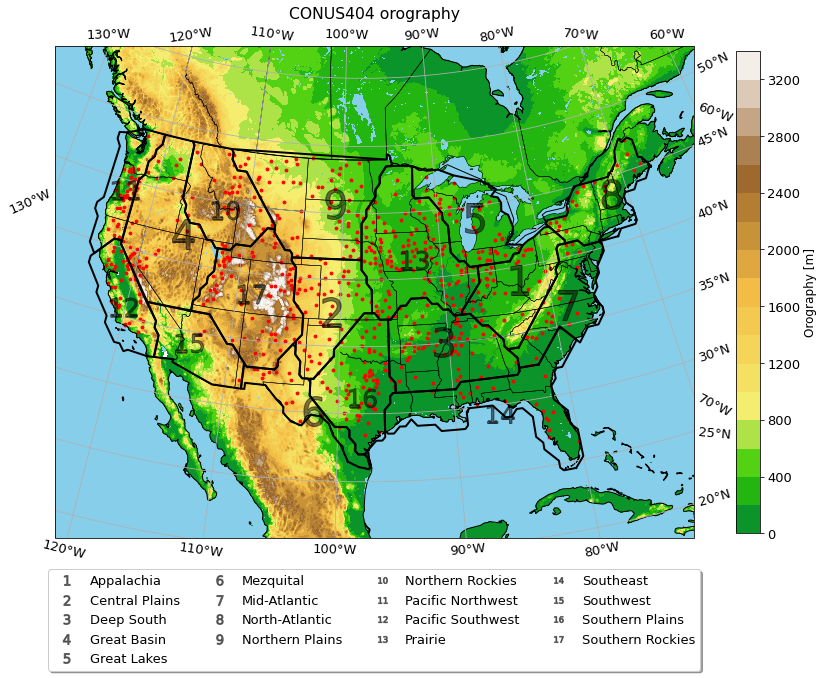

In [69]:
fig = plt.figure(figsize=(12.5,9.5))
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05, right=0.99,
           bottom=0.21, top=0.93,
           wspace=0.05, hspace=0.15)

# m = Basemap(llcrnrlat= 38 ,urcrnrlat=42,\
#             llcrnrlon=-79,urcrnrlon=-71,resolution='i',
#             projection='lcc', lat_1=30.,lat_2=50.,lat_0=40.07385,lon_0=-98.)
# ========= plot 4 km
#plot blue ocean and lakes
clevs=0

ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncid.close()


ax = plt.subplot(gs1[0,0], projection=cart_proj)
pos1 = ax.get_position()
cs = plt.contourf(Lon4, Lat4,LSM4[:],levels=[0,0.0001], colors = 'skyblue', transform=ccrs.PlateCarree())


clevs = np.arange(0,3600,200)
#Load ColorMap
from ExternalFunctions import gmtColormap
rgrColMap=gmtColormap(GMTPath='/glade/u/home/prein/MyPython_Programs/python/ColorMaps/', fileName='DEM_screen')
blue_red1 = LinearSegmentedColormap('BlueRed1', rgrColMap)
cs = plt.contourf(Lon4, Lat4,Height4[:],clevs, cmap=blue_red1, transform=ccrs.PlateCarree())

# Add COOP station locations
plt.scatter(LonSTCO[iSelect], LatSTCO[iSelect], color='r', s=8, transform=ccrs.PlateCarree())


# ================================
# NATIONAL CLIMATE ASSESSMENT REGIONS
# Add the subregions
import geopandas as gpd
from tqdm import tqdm

# data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/4th_ClimAssRegions.shp')
# # change CRS to epsg 4326
# Shapes = data.to_crs(epsg=4326)
# data = Shapes
# Coordinates = data['geometry']
# for sf in tqdm(range(len(data))):
#     try:
#         mycoordslist = np.array([list(x.exterior.coords) for x in Coordinates[sf].geoms])
# #         for kk in range(len(mycoordslist)):
# #             TEST = np.array(mycoordslist[kk])
# #             plt.plot(TEST[:,0],TEST[:,1], lw=5, c='k', transform=ccrs.PlateCarree())
        
#         kk = np.argmax([len(mycoordslist[ii]) for ii in range(len(mycoordslist))])
#         TEST = np.array(mycoordslist[kk])
# #         for ii in range(len(mycoordslist)-1):
# #             TEST = np.append(TEST, mycoordslist[ii+1], axis=0)
#     except:
#         TEST = np.array(Coordinates[sf].exterior.coords.xy)
#         TEST=TEST.T
#     plt.plot(TEST[:,0],TEST[:,1], lw=2, c='k', transform=ccrs.PlateCarree())
#     # label the region
#     XX = np.mean(TEST[:,0])
#     YY = np.mean(TEST[:,1])
    
#     plt.text(XX,YY, Shapes['STATE_NAME'][sf], fontsize=16, alpha=0.8, transform=ccrs.PlateCarree(), ha='center',va='center',weight="bold")
    
# ================================
# BUKOFSKY REGION
# Add the subregions
import geopandas as gpd
from tqdm import tqdm

REGIONS = [ 'Appalachia.shp',
            'CPlains.shp',
            'DeepSouth.shp',
            'GreatBasin.shp',
            'GreatLakes.shp',
            'Mezquital.shp',
            'MidAtlantic.shp',
            'NorthAtlantic.shp',
            'NPlains.shp',
            'NRockies.shp',
            'PacificNW.shp',
            'PacificSW.shp',
            'Prairie.shp',
            'Southeast.shp',
            'Southwest.shp',
            'SPlains.shp',
            'SRockies.shp']

REGIONS_names = [ 'Appalachia',
            'Central Plains',
            'Deep South',
            'Great Basin',
            'Great Lakes',
            'Mezquital',
            'Mid-Atlantic',
            'North-Atlantic',
            'Northern Plains',
            'Northern Rockies',
            'Pacific Northwest',
            'Pacific Southwest',
            'Prairie',
            'Southeast',
            'Southwest',
            'Southern Plains',
            'Southern Rockies']

for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    # change CRS to epsg 4326
#     Shapes = data['geometry'].to_crs(epsg=4326)
#     data = Shapes
    Coordinates = data['geometry']
    for sf in range(len(data)):
        try:
            mycoordslist = np.array([list(x.exterior.coords) for x in Coordinates[sf].geoms])
    #         for kk in range(len(mycoordslist)):
    #             TEST = np.array(mycoordslist[kk])
    #             plt.plot(TEST[:,0],TEST[:,1], lw=5, c='k', transform=ccrs.PlateCarree())

            kk = np.argmax([len(mycoordslist[ii]) for ii in range(len(mycoordslist))])
            TEST = np.array(mycoordslist[kk])
    #         for ii in range(len(mycoordslist)-1):
    #             TEST = np.append(TEST, mycoordslist[ii+1], axis=0)
        except:
            TEST = np.array(Coordinates[sf].exterior.coords.xy)
            TEST=TEST.T
        plt.plot(TEST[:,0],TEST[:,1], lw=2, c='k', transform=ccrs.PlateCarree())
        # label the region
        XX = np.mean(TEST[:,0])
        YY = np.mean(TEST[:,1])

        plt.plot(XX,YY, marker="$"+str(int(re+1))+"$", markersize=30, alpha=0.5, transform=ccrs.PlateCarree(), color='k') #, label=REGIONS[re][:-4], ha='center',va='center',weight="bold"
        plt.plot([],[], marker="$"+str(int(re+1))+"$", markersize=10, alpha=0.5, transform=ccrs.PlateCarree(), label=REGIONS_names[re], color='k', lw=0) #, ha='center',va='center',weight="bold"

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)

# Add a color bar
cb = plt.colorbar(cs, ax=ax, shrink=.98)
cb.set_label('Orography [m]', fontsize=12)

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.left_labels = False

plt.title('CONUS404 orography')


sPlotFile=sPlotDir
sPlotName= 'CONUS404-orography_Bukovdky-reg_COOP-Stats.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)
